# Comparing Total Hydrostatic Masses Between Analyses

This notebook measures hydrostatic masses for the samples we are using to verify our method, then compares them to the measurements from literature. These mass measurements include both the baryonic content of the intra-cluster medium, and that of the dark matter halo. This implicitly tests how close our measured temperature and density profiles are to those measured by the work we compare them to

The LoCuSS and Lovisari samples both have hydrostatic mass measurements associated with them which we will compare to, but the SDSSRM-XCS sample does not (such measurements will be presented in an upcoming paper), and the XXL-100-GC sample data is generally too shallow for such measurements.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from copy import deepcopy

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 60
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.sourcetools.mass import inv_abel_dens_onion_temp
from xga.models import DoubleBetaProfile1D, SimpleVikhlininDensity1D, SimpleVikhlininTemperature1D
from xga.exceptions import ModelNotAssociatedError

## Defining useful functions

In [2]:
# This function is used for getting axis limits for the the one to one comparison plots later
def find_lims(x_dat, y_dat, buffer=0.1):
    # A buffer of some percent (default 10) is added to the max and min values to make the plot 
    #  more easily readable
    lom = 1 - buffer
    him = 1 + buffer
    
    # Check if either are all NaNs
    if np.isnan(x_dat).all():
        x_dat = y_dat.copy()
    if np.isnan(y_dat).all():
        y_dat = x_dat.copy()
    
    # Reading out the values without errors
    x_vals = x_dat[:, 0]
    y_vals = y_dat[:, 0]
    
    # Depending on whether the input data has + and - errors, or just a standard deviation, depends how
    #  we find maximum and minimum values
    if x_dat.shape[1] == 3:
        # In this case upper and lower errors are present
        lb = x_vals-x_dat[:, 1]
        # Make sure that we don't count any NaN values, and don't count any negative values
        #  The lower errors are subtracted from the measurements, and upper values added to them
        #  Then max and mins are found 
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 2])]
    elif x_dat.shape[1] == 2:
        # The behaviour is largely the same as above, but for symmetrical errors
        lb = x_vals-x_dat[:, 1]
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 1])]
    
    if y_dat.shape[1] == 3:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 2])]
    elif y_dat.shape[1] == 2:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 1])]
    
    # Then find the minimum and maximum values from the min and max x and y data, and multiply by the buffer
    lims = Quantity([lom*min([x_lims[0], y_lims[0]]), him*max([x_lims[1], y_lims[1]])])
    
    # Return the limits for the square like for like comparison plot
    return lims

## Reading colour configuration file

In [3]:
samp_colours = pd.read_csv("samp_plot_colours.csv")

lov_colour = samp_colours[samp_colours['samp_name'] == 'lovisari'].iloc[0]['samp_colour']
loc_colour = samp_colours[samp_colours['samp_name'] == 'locuss'].iloc[0]['samp_colour']

## Setting up cosmology

The LoCuSS and Lovisari analyses use the same concordance cosmology, but the XXL analysis of their bright cluster sample uses the WMAP9 results, and in case we wish to change anything for an individual sample later we define three separate cosmology objects to pass into our samples.

In [4]:
locuss_cosmo = LambdaCDM(70, 0.3, 0.7)
lovisari_cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$ - XGA centering on

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [5]:
locuss = pd.read_csv("sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [6]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=True, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [04:27<07:52, 14.77s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [05:45<07:47, 17.32s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  54%|███████████████████████▊                    | 27/50 [06:20<04:33, 11.90s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/base.py:90: Us

Setting up Galaxy Clusters:  85%|██████████████████████████████████████▏      | 39/46 [07:03<01:57, 16.81s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for Abell2219 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: Abell2219 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for Abell2219 was not successful, or no matching spectrum has b

### Planck Selected with XMM follow-up

The Lovisari et al. sample was selected from Planck-eSZ, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [7]:
lovisari = pd.read_csv("sample_files/lovisari_planck_clusters.csv")

In [8]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = lovisari['xmm_ra'].values
dec = lovisari['xmm_dec'].values
z = lovisari['z'].values
n = lovisari['name'].values
r500 = Quantity(lovisari['r500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the Lovisari sample
lovisari_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=lovisari_cosmo, load_fits=True, use_peak=False, 
                            clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  50%|█████████████████████▌                     | 60/120 [16:11<12:28, 12.47s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.17-21.91 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0675470101/0675470101_mos2_G226.17-21.91_ra88.262_dec-21.062_ri0.0483332993719956_ro0.05437496179349506_grpTrue_mincnt5_ident72837747_6_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Declaring BaseSource Sample:  51%|█████████████████████▊                     | 61/120 [16:42<17:47, 18.10s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_mos2_G226.24x76.76_ra178.8

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280101/0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280101/0551280101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/x

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0603050101/0603050101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0603050101/0603050101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/xga_

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: G058.28+18.59 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  19%|████████▍                                   | 23/120 [05:23<27:22, 16.93s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0401920101 and is very close to the user supplied coordinates of G062.42-46.41. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: G062.42-46.41 has 

Setting up Galaxy Clusters:  40%|█████████████████▌                          | 48/120 [09:20<11:45,  9.79s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.19574984170276016_ro0.20179150348370956_grpTrue_mincnt5_ident20760763_32_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.08579159728948131_ro0.0918332590704307_grpTrue_mincnt5_ident20760763_14_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/its/home/dt237/.conda/

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.19574993198391719_ro0.20783326111872688_grpTrue_mincnt5_ident40542796_29_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.1401665533180258_ro0.1462082150989752_grpTrue_mincnt5_ident20760763_23_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.0_r

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.12808328882898284_ro0.1341249533963877_grpTrue_mincnt5_ident40542796_21_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.03315075373638254_ro0.22100502490921697_grpTrue_mincnt5_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.10391658263232947_r

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.07974997228974404_ro0.08579163685714888_grpTrue_mincnt5_ident40542796_13_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.14741661544467838_ro0.15345828001208323_grpTrue_mincnt5_ident83707019_24_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.1462082825311974_ro0.15224

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: G164.18-38.89 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.19574984170276016_ro0.20179150348370956_grpTrue_mincnt5_ident20760763_32_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.08579159728948131_ro0.0918332

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.15224987687992458_ro0.1594998710170638_grpTrue_mincnt5_ident20760763_25_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.0_ro0.22100502490921697_grpTrue_mincnt5_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.1039166305

Setting up Galaxy Clusters:  41%|█████████████████▉                          | 49/120 [09:29<11:21,  9.60s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G166.13+43.39 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  42%|██████████████████▋                         | 51/120 [09:43<09:28,  8.24s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G171.94-40.65 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  44%|███████████████████▍                        | 53/120 [10:00<09:50,  8.8

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280101/0551280101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280101/0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/xga

Setting up Galaxy Clusters:  52%|███████████████████████                     | 63/120 [11:57<13:13, 13.93s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G228.49+53.12 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  54%|███████████████████████▊                    | 65/120 [12:10<09:19, 10.16s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: G229.94+15.29 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  58%|█████████████████████████▋                  | 70/120 

Setting up Galaxy Clusters:  73%|████████████████████████████████▎           | 88/120 [15:40<05:03,  9.49s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: G272.10-40.15 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/extended.py:164: UserWarning: After applying the criteria for the minimum amount of cluster required on an observation, G272.10-40.15 cannot be declared as all potential observations were removed
  warn("After applying the criteria for the minimum amount of cluster required on an "
Setting up Galaxy Clusters:  77%|█████████████████████████████████▋          | 92/120 [16:14<04:10,  8.96s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/x

## Running PSF Correction

In [9]:
rl_psf(locuss_srcs)
rl_psf(lovisari_srcs)

Generating products of type(s) image: 100%|█████████████████████████████████████| 8/8 [00:02<00:00,  2.70it/s]


## Reading in literature data

###   $\color{red}{\text{Hydrostatic masses from literature}}$

In [10]:
lov_lit_ms = [lovisari[lovisari['name'] == n].iloc[0][['m500', 'm500-', 'm500+']].values*1e+14
               for n in lovisari_srcs.names]
lov_lit_ms = Quantity(lov_lit_ms, 'Msun')

loc_lit_ms = [locuss[locuss['name'] == n].iloc[0][['x_m500', 'x_m500_err']].values
               for n in locuss_srcs.names]
loc_lit_ms = Quantity(loc_lit_ms, 'Msun')

### Conversion Temperatures

In [11]:
loc_conv_txs = []
lov_conv_txs = []

for src in lovisari_srcs:
    lov_conv_txs.append(lovisari[lovisari['name'] == src.name].iloc[0]['Tx'])
    
lov_conv_txs = Quantity(lov_conv_txs, 'keV')
    
for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

loc_conv_txs = Quantity(loc_conv_txs, 'keV')

## Hydrostatic Mass Comparison to Literature - Density from $S_B$ Profiles

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.05$R_{500}$

In [12]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [13]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [14]:
demo_t_mod = SimpleVikhlininTemperature1D()
demo_t_mod.info()
demo_t_mod.par_priors

╒════════════════════════════════╤═════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                     │
╞════════════════════════════════╪═════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Temperature                                                     │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ keV                                                                 │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ r_cool, a_cool, t_min, t_zero, r_tran, c_power                      │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ kpc, , keV, keV, kpc

[{'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'}]

In [15]:
loc_sb_dblbeta_simpvikh_105_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.05, 'double_beta', 
                                                          'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                          temp_min_snr=30)

Running XSPEC Fits: 100%|██████████████████████████████████████████████████████| 1/1 [02:29<00:00, 149.33s/it]
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/temperature.py:152: UserWarning: The requested annuli for RXCJ1212.3-1816 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
Generating products of type(s) spectrum: 100%|█████████████████████████████████| 9/9 [22:53<00:00, 152.58s/it]
Generating products of type(s) annular spectrum set components: 100%|███████| 144/144 [22:13<00:00,  9.26s/it]
Running XSPEC Fits: 100%|█████████████████████████████████████████████████████| 45/45 [03:11<00:00,  4.25s/it]
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/xspec/run.py:326: UserWarning: Abell0963 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit 

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1668.78566203 1153.79416153 1669.81330698 1403.77908148 1477.60290088
 1446.43598998]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▍       | 2/41 [00:52<17:15, 26.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [618.08030513 469.92469344 700.78568793 640.93180868 654.13382737
 743.38493676]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/41 [01:18<16:33, 26.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1566.50113788  723.59739354 1503.60251188 1063.9493741  1225.91919751
 1492.09863888]


Fitting data, inverse Abel transforming, and measuring densities:  10%|▊       | 4/41 [01:43<15:44, 25.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1124.4062112  1068.56849852 1918.50229392 1250.72216787  951.712346
 1643.35532115]


Fitting data, inverse Abel transforming, and measuring densities:  12%|▉       | 5/41 [02:07<15:07, 25.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [209.17549941 506.04779389 113.11655094 131.46270242 209.36708547
 272.79337089]


Fitting data, inverse Abel transforming, and measuring densities:  15%|█▏      | 6/41 [02:31<14:30, 24.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1609.74389454 1517.51177268 1763.92538886 1129.02500985 1812.6337326
 1777.85876357]


Fitting data, inverse Abel transforming, and measuring densities:  20%|█▌      | 8/41 [03:24<14:00, 25.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 293.82087515  324.63654115 2046.841734   1920.55741596 1967.66025886
 1952.3467046 ]


Fitting data, inverse Abel transforming, and measuring densities:  32%|██▏    | 13/41 [05:37<12:11, 26.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1181.92384185  232.21487241 1180.78375798  991.97177359 1110.0568246
 1030.76425051]


Fitting data, inverse Abel transforming, and measuring densities:  34%|██▍    | 14/41 [06:02<11:43, 26.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [982.57846263 990.08514716 866.36054509 833.52168767 891.72413035
 977.36082754]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 20/41 [08:38<08:56, 25.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [210.83782427 448.75074064 971.84503638 210.05041749 219.66201519
 201.36072887]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 21/41 [09:04<08:30, 25.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [167.85162375 412.37892423 325.4024446  543.86428554 555.44820584
 499.49176382]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 23/41 [09:57<07:47, 25.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [131.57000228 514.52690603 156.95153496 174.76994037 199.53566604
 275.76683614]


Fitting data, inverse Abel transforming, and measuring densities:  59%|████   | 24/41 [10:24<07:23, 26.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1151.97364729  915.02665355 2071.88751813 1641.02218244 1874.77538324
 2092.60342602]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 29/41 [12:40<05:17, 26.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1001.04139596 1560.3305282  1544.54567982 1839.51139479 1939.14551908
 1740.9434743 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [486.6983968  354.71732017  43.76844819 175.46573191 166.7977771
  63.1219682 ]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 31/41 [13:31<04:19, 25.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1052.17537317  750.29066898 1270.30794202 1112.91003484 1210.25019637
 1386.05583987]


Fitting data, inverse Abel transforming, and measuring densities:  83%|█████▊ | 34/41 [14:56<03:11, 27.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [790.90848979 821.01704842 881.71196483 700.95638206 840.69865077
 876.0036394 ]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▍| 38/41 [16:47<01:21, 27.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1258.32268122  809.58859042 1293.18077584 1053.40518703 1240.63261713
 1395.77675734]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 41/41 [18:03<00:00, 26.42s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1120.86997265  262.3382449  2153.54612305 2043.34421479 1690.00453575
 2144.24833952]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/46 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [113.52472799 153.90913326 886.16976264 108.47379182 111.60088415
 364.55956684]


Generating Abell0068 hydrostatic mass profile:   2%|▌                          | 1/46 [00:28<21:33, 28.75s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [112.59445662 124.03297655 417.30994466 105.73483586 120.50607308
 136.33055116]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/46 [00:57<21:15, 29.00s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.26788993 133.98267673 674.63208147 108.42457538 102.93773718
 299.13259513]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/46 [01:26<20:42, 28.90s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 167.73580932  199.36034753 1787.42111416  212.32366542  221.05755636
  329.58202461]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/46 [01:54<19:50, 28.33s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [410.88213933 399.39056844 190.26046972 355.66459591 161.22744448
 271.51190216]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/46 [02:21<19:13, 28.15s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/46 [02:46<17:54, 26.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 142.67157181  152.91183035 1104.57667316  195.98395713  209.94053072
  143.54782882]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [387.82142042 590.19702425 732.31796563 246.42129723 416.23350746
 668.57819842]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0267 hydrostatic mass profile:  15%|████                       | 7/46 [03:17<18:20, 28.22s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  95.33474833   93.88709995 1183.85683666   97.53537958  123.6736716
   99.94856736]


Generating Abell0291 hydrostatic mass profile:  17%|████▋                      | 8/46 [03:45<17:52, 28.22s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrap

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.0818501   85.58048251 627.73368017  87.19199787  86.08246203
  85.60807594]


Generating Abell0383 hydrostatic mass profile:  20%|█████▎                     | 9/46 [04:15<17:40, 28.66s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating Abell0521 hydrostatic mass profile:  22%|█████▋                    | 10/46 [04:43<17:07, 28.55s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [330.10511699 429.50838364 163.33450734 163.08571841 156.29991803
 430.02275848]


Generating Abell0586 hydrostatic mass profile:  24%|██████▏                   | 11/46 [05:11<16:37, 28.50s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.54137211  97.29624925 495.39816053  97.26639659 101.11645566
  99.97214361]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0611 hydrostatic mass profile:  26%|██████▊                   | 12/46 [05:41<16:17, 28.74s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [366.70792172 449.18097346 561.01194346 248.32025855 165.1911928
 484.44246361]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  30%|██████              | 14/46 [06:08<15:10, 28.44s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating Abell0750 hydrostatic mass profile:  33%|████████▍                 | 15/46 [06:36<11:08, 21.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 106.96432568  109.17873412 1079.68993265  110.74121258  120.3237423
  117.3645659 ]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or d

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [787.94216612 607.96171769 263.94259013 694.78152605 306.99312182
 262.58281264]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [400.3994385  369.77572316 155.79084578 351.56964139 457.90594014
 268.94234522]


Generating Abell0901 hydrostatic mass profile:  39%|██████████▏               | 18/46 [07:30<08:51, 18.99s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 87.63670509  90.055366   481.79250732  98.39134934 101.2176496
  83.47477744]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0907 hydrostatic mass profile:  41%|██████████▋               | 19/46 [08:00<09:39, 21.48s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating ZwCl1021.0+0426 hydrostatic mass profile:  46%|█████████▏          | 21/46 [08:31<09:56, 23.87s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simpl

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 92.37403679  98.59162365 672.06773322  86.21671672 120.11652871
  79.90313317]


Generating RXCJ1212.3-1816 hydrostatic mass profile:  50%|██████████          | 23/46 [08:58<07:33, 19.70s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating ZwCl1231.4+1007 hydrostatic mass profile:  52%|██████████▍         | 24/46 [09:23<06:12, 16.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [900.30097315 728.42845116 610.69539813 942.57148039 412.90347784
 612.59571997]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [100.91073697 118.03163726 457.43119418 122.70380889 103.53298471
 168.22314996]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1689 hydrostatic mass profile:  54%|██████████████▏           | 25/46 [09:51<06:46, 19.34s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrap

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1514.27876244 1799.75671576 1648.46382117 1737.09519684  835.48520271
 1789.79273008]


Generating Abell1763 hydrostatic mass profile:  59%|███████████████▎          | 27/46 [10:55<07:46, 24.56s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [283.34898842 411.02754659 757.72363224 272.59232803 251.92884604
 613.16372853]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1835 hydrostatic mass profile:  61%|███████████████▊          | 28/46 [11:27<07:53, 26.28s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 73.61297942  77.83032204 670.18355446  77.80480913  66.90303517
  66.29104865]


Generating Abell1914 hydrostatic mass profile:  63%|████████████████▍         | 29/46 [11:58<07:51, 27.76s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 88.68045526 100.83146358 531.53346326  89.67596744  87.14823618
 108.85441022]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1454.8+2233 hydrostatic mass profile:  65%|█████████████       | 30/46 [12:31<07:48, 29.28s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  91.40103227   93.51248534 1047.99709509  102.01828314  136.93697796
   99.21486967]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████▌        | 31/46 [12:59<07:10, 28.69s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [124.05636397 312.69134182 720.27837135  95.85443348 127.61996508
 446.37222774]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1459.4+4240 hydrostatic mass profile:  70%|█████████████▉      | 32/46 [13:32<07:00, 30.04s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [478.61711143 944.22629901 348.02161458 406.32097781 585.78007285
 570.06471131]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  72%|██████████████▎     | 33/46 [14:01<06:24, 29.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [644.37362719 797.98036056 261.80089222 658.97042497 243.74444108
 275.26887364]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  58.55779031   66.64680405 1073.18217548   85.87198662   82.95156789
   34.08026212]


Generating Abell2111 hydrostatic mass profile:  74%|███████████████████▏      | 34/46 [14:56<07:27, 37.25s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 713.62149252 1450.51435844 1693.2408799   360.38279541  314.93160922
 1640.16015573]


Generating Abell2204 hydrostatic mass profile:  76%|███████████████████▊      | 35/46 [15:27<06:29, 35.38s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 94.52830874  85.6569534  488.64657996  94.45523601  95.66094779
  74.01994649]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▉    | 37/46 [16:03<05:19, 35.46s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 87.9862288   85.35716983 678.68573326  82.65395519  87.12267404
  65.40871379]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2261 hydrostatic mass profile:  83%|█████████████████████▍    | 38/46 [16:35<03:33, 26.67s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating RXCJ2102.1-2431 hydrostatic mass profile:  85%|████████████████▉   | 39/46 [17:06<03:13, 27.65s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: So

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.34286592  84.88182806 754.9743711   81.7400477   80.25773957
  86.77431146]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▎  | 40/46 [17:36<02:50, 28.35s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.53481527  90.21681746 485.39580437  93.14674178  90.31361536
  87.92830696]


Generating Abell2390 hydrostatic mass profile:  89%|███████████████████████▏  | 41/46 [18:06<02:23, 28.71s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 79.25522779  78.90690493 514.09875681  82.42339508  82.62521203
  76.471516  ]


Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 42/46 [18:38<01:58, 29.71s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [186.38389166 581.78120973 956.1383999  152.64440008 128.76705757
 781.32125018]


Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 43/46 [19:06<01:27, 29.21s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [294.24530863 455.11852254 612.32297929 196.70153474 289.69764931
 455.98910576]


Generating Abell2631 hydrostatic mass profile:  96%|████████████████████████▊ | 44/46 [19:36<00:58, 29.29s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 665.07404464 1551.31026211  876.35039704  772.98713059 1196.46300026
 1321.68831246]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████▍| 45/46 [20:06<00:29, 29.56s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [109.31564447 117.46766328 797.9597549  109.27607019 116.12824053
 156.70965455]


Complete: 100%|███████████████████████████████████████████████████████████████| 46/46 [20:34<00:00, 26.84s/it]


In [16]:
lov_sb_dblbeta_simpvikh_105_mp = inv_abel_dens_onion_temp(lovisari_srcs, lovisari_srcs.r500*1.05, 'double_beta', 
                                                          'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                          temp_min_snr=30)

Running XSPEC Fits: 100%|█████████████████████████████████████████████████████| 18/18 [03:06<00:00, 10.37s/it]
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/mass.py:51: UserWarning: The global temperature fit for G042.82+56.61 has failed, and as such we're very unlikely to be able to measure a mass and we're not even going to try.
  warn("The global temperature fit for {} has failed, and as such we're very unlikely to be able to measure "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/mass.py:51: UserWarning: The global temperature fit for G171.94-40.65 has failed, and as such we're very unlikely to be able to measure a mass and we're not even going to try.
  warn("The global temperature fit for {} has failed, and as such we're very unlikely to be able to measure "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/mass.py:51: UserWarning: The global temperature fit for G229.94+15.29 has fai

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 574.60673956  505.25671083  457.35097111  863.52645343  969.73433955
 1171.98852528]


Fitting data, inverse Abel transforming, and measuring densities:  69%|████▊  | 68/99 [30:24<13:30, 26.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 735.13857377 1147.22491665 2277.14298324 2151.31200405 2205.41777602
 2262.0490808 ]


Fitting data, inverse Abel transforming, and measuring densities:  70%|████▉  | 69/99 [30:47<12:37, 25.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 450.93602377  285.03598155 1629.19812479 1630.61587726 1656.10276726
 1629.29213898]


Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 71/99 [31:43<12:23, 26.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [162.36214221 408.52966335 215.25421738 164.83342742 240.67314885
 274.68157974]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 75/99 [33:27<10:12, 25.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [268.13769775 310.31297166 630.66675983 257.17540296 274.12427047
 321.86060044]


Fitting data, inverse Abel transforming, and measuring densities:  77%|█████▎ | 76/99 [33:53<09:50, 25.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [169.87677497 372.38438365 154.43085792 427.92282497 437.430006
 385.09532482]


Fitting data, inverse Abel transforming, and measuring densities:  79%|█████▌ | 78/99 [34:41<08:35, 24.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 855.84891666 1388.0355515  1963.13089367 2067.27803567 2009.92978798
 1955.63011624]


Fitting data, inverse Abel transforming, and measuring densities:  81%|█████▋ | 80/99 [35:33<07:57, 25.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [697.69110214 196.31194565 770.28336857 832.07997316 875.80108249
 799.84210659]


Fitting data, inverse Abel transforming, and measuring densities:  82%|█████▋ | 81/99 [35:56<07:23, 24.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [404.86618214 577.44570836 509.17240201 516.94913481 604.06312032
 753.99962442]


Fitting data, inverse Abel transforming, and measuring densities:  83%|█████▊ | 82/99 [36:20<06:56, 24.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [464.52934434 586.00553318 641.6896875  446.71627566 474.79565117
 571.02203685]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [234.13235803 427.2762232  163.24943302 204.44633973 215.22886187
 230.80982702]


Fitting data, inverse Abel transforming, and measuring densities:  85%|█████▉ | 84/99 [37:17<06:33, 26.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [535.27862787 693.31708696 308.55768093 531.36170947 551.08329291
 585.05269088]


Fitting data, inverse Abel transforming, and measuring densities:  86%|██████ | 85/99 [37:42<06:01, 25.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [181.30090938 305.87509219 392.50898102 264.79549788 322.76958599
 405.05941921]


Fitting data, inverse Abel transforming, and measuring densities:  87%|██████ | 86/99 [38:05<05:26, 25.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 378.99597853 1125.37455582 1911.63698956 1184.22359124 1556.51472434
 1639.39691285]


Fitting data, inverse Abel transforming, and measuring densities:  94%|██████▌| 93/99 [41:38<03:04, 30.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [255.53656962 404.75017188 414.69143915 357.26023761 416.91513465
 470.6316324 ]


Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 94/99 [42:06<02:29, 29.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [424.760709   896.7735604  637.57369346 960.1434196  963.93402371
 841.15688443]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 96/99 [42:59<01:23, 27.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [292.04909472 707.08435304 119.82145945 532.05978175 609.70533477
 499.17185179]


Fitting data, inverse Abel transforming, and measuring densities:  99%|██████▉| 98/99 [43:49<00:26, 26.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 838.0751739  1058.08985089 1664.18936838 1472.98870902 1541.45129095
 1666.93170448]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 99/99 [44:16<00:00, 26.83s/it]
Generating G002.74-56.18 hydrostatic mass profile:   1%|▏                   | 1/119 [00:00<00:00, 2933.08it/s]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [710.15729296 963.79704394 710.55695142 819.1298179  602.36408866
 534.15655963]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 82.47986775  85.44932562 462.73604731  83.03702635  77.54543315
  95.49509857]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G003.90-59.41 hydrostatic mass profile:   2%|▎                     | 2/119 [00:53<52:08, 26.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [106.3071612  132.34581243 639.00649983 103.62139133 132.11286062
 361.14829585]


Generating G006.70-35.54 hydrostatic mass profile:   3%|▌                   | 3/119 [01:49<1:15:07, 38.86s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [591.32175593 413.4637016  263.44731584 677.67466698 443.19061426
 422.58999328]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1772.0733578  1966.70756999  804.60834711 1485.38504116  950.17390607
 1978.95899775]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/mass.py:209: UserWarning: A mass of less than zero was measured by a hydrostatic mass profile, this is not physical and the profile is not valid.
  warn("A mass of less than zero was measured by a hydrostatic mass profile, this is not physical"
Generating G008.44-56.35 hydrostatic mass profile:   4%|▊                   | 5/119 [02:48<1:28:14, 46.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1226.83024868 1299.1609073   873.34959832 1139.26410964  769.94359299
  787.51837695]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 85.83913961  88.34073489 702.92290019  88.2997803   83.93093345
  85.25204022]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G008.93-81.23 hydrostatic mass profile:   5%|█                   | 6/119 [03:41<1:07:55, 36.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [872.96779107 758.1903423  662.35546579 659.54403367 801.97206881
 666.62723135]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  89.12489194   82.93914648 1263.38868563   92.86722653   53.66508003
   75.66852993]


Generating G021.09+33.25 hydrostatic mass profile:   6%|█▏                  | 7/119 [04:29<1:13:36, 39.44s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 80.63315881  78.99209445 654.2643812   79.81458365  86.65830634
  65.74301882]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G036.72+14.92 hydrostatic mass profile:   7%|█▎                  | 8/119 [05:27<1:22:18, 44.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [667.13402925 648.27532469 664.52012246 732.74540143 476.18844185
 471.57122351]


Generating G039.85-39.98 hydrostatic mass profile:   8%|█▌                  | 9/119 [06:20<1:26:02, 46.93s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [495.01762577 605.59083625 535.06098514 748.3782678  487.83911343
 473.28376868]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 214.2922754   939.36589922 1741.48761085  168.70018393  158.28434767
 1292.80984432]


Generating G046.08+27.18 hydrostatic mass profile:   9%|█▊                 | 11/119 [07:11<1:26:28, 48.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [665.47569753 826.6450801  515.86633067 845.25806226 846.73281921
 766.89032283]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1182.94567891 1541.78314686 1530.92642953 1616.27253825 1259.81182741
 1612.43015107]


Generating G046.50-49.43 hydrostatic mass profile:  10%|█▉                 | 12/119 [07:58<1:06:02, 37.03s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G049.20+30.86 hydrostatic mass profile:  11%|██                 | 13/119 [09:05<1:18:28, 44.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [566.35204338 579.43637769 264.56242014 534.39482525 271.16216947
 271.79877583]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.02474518  83.70437463 932.55205674  83.41193629  80.97841101
  84.64394198]


Generating G049.33+44.38 hydrostatic mass profile:  12%|██▏                | 14/119 [10:01<1:22:43, 47.27s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [630.33676352 819.19044581 647.99775481 830.03428988 517.98794338
 574.98732615]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [105.17481212 110.63633537 442.87259111 103.39135959 103.6883
 113.18235849]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G049.66-49.50 hydrostatic mass profile:  13%|██▍                | 15/119 [10:56<1:25:27, 49.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [662.46919049 599.06821131 417.23687457 521.16269429 221.35757543
 432.37324736]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.2613348   89.12895782 495.98747009  84.83925114  90.22149736
  89.41305836]


Generating G053.52+59.54 hydrostatic mass profile:  13%|██▌                | 16/119 [11:56<1:29:40, 52.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1095.82058009 1608.35087781 1472.40313622 1412.13363841 1328.91201467
 1567.31790568]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [524.4707363  513.65717561 135.15008437 285.25864714 539.87477391
 335.38374006]


Generating G055.60+31.86 hydrostatic mass profile:  14%|██▋                | 17/119 [12:52<1:31:04, 53.57s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [441.94155862 904.94108593 405.51902776 555.39535423 420.92613493
 453.9752505 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 91.10356254  89.32756992 461.14230814  87.14912797  90.14288895
  85.43475812]


Generating G055.97-34.88 hydrostatic mass profile:  15%|██▊                | 18/119 [13:44<1:29:12, 53.00s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 650.35615382 1935.09344684 2101.88974653 1724.41762571  372.76672238
  966.59550998]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [538.63241676 492.55441694 198.79119306 416.40292948 331.15817767
 241.11844306]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G056.81+36.31 hydrostatic mass profile:  16%|███                | 19/119 [14:36<1:27:48, 52.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1421.65644895 1581.02645826 1139.53937381 1273.27601828  857.5202736
 1028.97347009]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G056.96-55.07 hydrostatic mass profile:  17%|███▏               | 20/119 [15:36<1:30:22, 54.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1289.58648641 1477.3314598   923.76756258 1350.05276397 1009.17459046
 1247.73361095]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1013.30815216 1077.1601301   572.38615409 1133.49482492  873.19775476
  924.00193335]


Generating G057.26-45.35 hydrostatic mass profile:  18%|███▎               | 21/119 [16:25<1:26:46, 53.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [306.47355052 626.09773788 644.88776696 516.51587452 378.82731357
 400.6581626 ]


Generating G062.42-46.41 hydrostatic mass profile:  19%|███▋               | 23/119 [17:12<1:22:13, 51.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [622.90615625 534.27315297 657.06258041 780.21222092 417.90775439
 417.24424222]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 99.75501501 126.98519154 428.69328106 104.75356381  71.37825412
 123.98659006]


Generating G067.23+67.46 hydrostatic mass profile:  20%|███▊               | 24/119 [18:09<1:04:49, 40.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [480.92028457 881.11834117 506.94353183 685.035251   399.56296547
 512.93925494]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.80404344 123.64277445 565.83184426  91.36650926 105.99303486
 136.3990325 ]


Generating G071.61+29.79 hydrostatic mass profile:  21%|███▉               | 25/119 [19:03<1:09:03, 44.08s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 783.41063722  870.96763109  954.70579022 1013.99387667  721.03643124
  778.7806504 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1213.98146046 1557.87431155 1073.68206846  967.6950193  1231.52290769
 1356.97902444]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G072.80-18.72 hydrostatic mass profile:  23%|████▎              | 27/119 [19:56<1:10:59, 46.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [423.97379079 617.88256657 310.78208004 563.04141424 215.67577263
 210.73793948]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.14683927 109.69877728 720.41320849  86.84310918  83.3587621
 117.17327736]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G073.96-27.82 hydrostatic mass profile:  24%|████▉                | 28/119 [20:52<58:19, 38.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 79.81327999  89.33294908 703.86974134  77.91373295  78.28196713
  90.19192897]


Generating G080.38-33.20 hydrostatic mass profile:  24%|████▋              | 29/119 [21:47<1:03:29, 42.33s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [547.19369278 761.51415533 944.649359   676.92112236 583.89524954
 587.64186711]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [112.8881894  114.71494456 565.31738425 114.57312141 116.57662323
 129.42851176]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G080.99-50.90 hydrostatic mass profile:  25%|████▊              | 30/119 [22:43<1:07:54, 45.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [428.42421077 906.90061508 701.20112337 632.29589317 434.06513756
 536.9517808 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 92.86756714 102.09138264 445.51195208  88.93649405  91.5553588
 111.09385943]


Generating G083.28-31.03 hydrostatic mass profile:  26%|████▉              | 31/119 [23:32<1:08:37, 46.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [759.22128126 630.19427541 577.91916733 593.55354725 684.39566535
 691.18040941]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [216.58643041 522.38432313 726.04506723 156.13303052 140.65497903
 644.7809253 ]


Generating G085.99+26.71 hydrostatic mass profile:  27%|█████              | 32/119 [24:19<1:07:58, 46.88s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 970.11413598  939.8847619   972.06818563 1018.48531376  698.02936757
  960.48811359]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [774.81789454 756.08870059 371.32402402 650.15818328 470.46648509
 483.25363883]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G086.45+15.29 hydrostatic mass profile:  28%|█████▎             | 33/119 [25:09<1:08:23, 47.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [136.85559703 171.09696509 458.83838993 248.59470408 380.82544269
 217.28375442]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [132.67639021 141.61929475 552.551317   123.23035547 126.37444477
 158.47346578]


Generating G092.73+73.46 hydrostatic mass profile:  29%|█████▍             | 34/119 [26:02<1:09:32, 49.09s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [564.29500621 557.76032086 540.91958107 501.18117435 393.55438298
 392.24928797]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [179.80739485 481.18120562 990.57763412 227.9379714  225.67893897
 791.14532968]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G096.87+24.21 hydrostatic mass profile:  30%|█████▋             | 36/119 [26:52<1:08:30, 49.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [475.36075916 612.59676276 479.3406567  455.26811164 419.91557786
 483.06539649]


Generating G097.73+38.11 hydrostatic mass profile:  31%|██████▌              | 37/119 [27:39<51:30, 37.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 261.24279935  841.57203383 1980.91563878  231.16481586  191.24208764
  918.73546248]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1368.01302012 1476.7595222  1923.28147774 1850.56504129 1097.63710043
 1290.59569789]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1679.43950408 1850.18752913 1447.25598681  740.04065429 1752.4851049
 1774.3448598 ]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G098.95+24.86 hydrostatic mass profile:  32%|██████▋              | 38/119 [28:34<56:38, 41.96s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 746.7504676  1032.0891279  1034.52783528 1048.14826712  340.24574313
  479.75972715]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G106.73-83.22 hydrostatic mass profile:  33%|██████▏            | 39/119 [29:32<1:01:28, 46.10s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/models/temperature.py:109: RuntimeWarning: overflow encountered in power
  cool_expr = ((t_min / t_zero) + (x / r_cool)**a_cool) / (1 + (x / r_cool)**a_cool)
/its/home/dt237/.conda/envs/xga_env/lib/

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [564.75221938 969.88940478 491.39107435 505.89214216 485.10473156
 635.01868668]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 99.39815003 103.8910654  897.97566883 117.69020448 124.35418381
 226.54569898]


Generating G107.11+65.31 hydrostatic mass profile:  34%|██████▍            | 40/119 [30:20<1:01:19, 46.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [464.53652576 598.52028524 526.88919169 666.99308434 382.92426772
 507.13705027]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [350.21027737 572.79372517 547.90470965 122.98932718 411.29412018
 592.27528798]


Generating G113.82+44.35 hydrostatic mass profile:  34%|██████▌            | 41/119 [31:09<1:01:10, 47.06s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1232.78893349 1192.56873918 2395.76826073  745.23012572  422.54102022
  621.67444679]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G124.21-36.48 hydrostatic mass profile:  35%|██████▋            | 42/119 [31:57<1:00:58, 47.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  95.41369603   96.66445316 1325.7849441    96.2174855   143.46330539
  103.3286162 ]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G125.70+53.85 hydrostatic mass profile:  36%|██████▊            | 43/119 [32:49<1:01:42, 48.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [338.7429994  649.97773748 436.44469433 349.44781522 336.9291771
 278.47260561]


Generating G139.19+56.35 hydrostatic mass profile:  37%|███████            | 44/119 [33:37<1:00:32, 48.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [129.71308975 203.33593145 540.53497245 128.14337621 125.83766032
 401.38171591]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [472.07086456 491.1788323  460.24888854 494.16902661 415.02688103
 370.4322246 ]


Generating G149.73+34.69 hydrostatic mass profile:  38%|███████▉             | 45/119 [34:23<59:08, 47.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 626.55391442 1156.34023222 1179.72763266 1337.99154967  696.36374108
 1290.59733637]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1405.09775053 1348.35601908 1245.9460131  1375.99543796  736.34878349
 1491.17011725]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G157.43+30.33 hydrostatic mass profile:  39%|████████             | 46/119 [35:15<59:37, 49.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [423.16523259 441.14792537 502.44295118 480.5051396  350.05581154
 381.97677707]


Generating G159.85-73.47 hydrostatic mass profile:  39%|████████▎            | 47/119 [36:02<58:03, 48.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1440.44670565 2253.09395998 1536.79381791 1468.94077661 1731.50479851
 1948.20643923]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [576.4330058  740.26100406 866.23043249 705.55109849 478.58886372
 726.15998694]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 760.3455431  1033.21015875  811.6076137   572.74488991  789.16570628
 1056.03344487]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G166.13+43.39 hydrostatic mass profile:  41%|████████▋            | 49/119 [36:54<57:54, 49.64s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/models/temperature.py:109: RuntimeWarning: overflow encountered in power
  cool_expr = ((t_min / t_zero) + (x / r_cool)**a_cool) / (1 + (x / r_cool)**a_cool)
/its/home/dt237/.conda/envs/xga_env/lib/

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [405.40950419 819.90968268 374.24939476 448.91442103 310.04353524
 268.39656052]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 99.66936439 103.66128207 717.68494833 102.35420916 123.18555128
 102.56353878]


Generating G167.65+17.64 hydrostatic mass profile:  42%|████████▊            | 50/119 [37:44<43:55, 38.20s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [535.93829675 643.04002398 558.26446054 501.91676859 912.79055276
 473.39899758]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1561.36425262 2375.97137007 1896.20779306 2279.24949465 1517.28167054
 2071.5615089 ]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G180.24+21.04 hydrostatic mass profile:  44%|█████████▏           | 52/119 [38:36<46:27, 41.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 91.90142775  89.28552606 681.68139592  90.99158447  47.22224041
  85.38584499]


Generating G186.39+37.25 hydrostatic mass profile:  46%|█████████▋           | 55/119 [39:24<36:42, 34.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1408.46362802  673.15179962 1617.98329882  410.12407206  306.36096376
  298.45059797]


Generating G195.62+44.05 hydrostatic mass profile:  47%|█████████▉           | 56/119 [40:13<27:06, 25.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 239.74324571  572.51306383 1020.19023835  168.5621072   124.98283488
  893.85936357]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [355.96968926 665.26410386 463.22462633 513.94622371 390.55698575
 442.96521604]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 102.65447988  118.10065719 1007.3161706   105.26698559  145.80479181
  125.082323  ]


Generating G195.77-24.30 hydrostatic mass profile:  48%|██████████           | 57/119 [41:01<30:48, 29.82s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [546.5302176  868.16290099 663.38772275 864.4890049  541.94611548
 610.87938501]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 911.73865768  985.99194401 1947.43392858  674.91251351  914.50026186
 1372.65114682]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G218.85+35.50 hydrostatic mass profile:  49%|██████████▏          | 58/119 [41:53<35:09, 34.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [763.63556642 984.16088298 631.90886198 749.74884081 573.66009066
 628.10752183]


Generating G225.92-19.99 hydrostatic mass profile:  50%|██████████▍          | 59/119 [42:43<38:05, 38.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [536.70868495 516.206962   194.52081848 545.77965686 291.16867265
 302.99271292]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 668.04410515  927.83608891  871.74328529 1005.38297909  654.43329203
  876.37786955]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1043.35971859  593.13192367  502.73394745 1075.77656158  797.35558769
  482.14592786]


Generating G226.17-21.91 hydrostatic mass profile:  50%|██████████▌          | 60/119 [43:28<38:57, 39.63s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 614.16926553 1115.34514091 1161.32727011  875.23746065  614.37227969
  592.94220668]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G226.24+76.76 hydrostatic mass profile:  51%|██████████▊          | 61/119 [44:26<43:00, 44.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 77.75807531  89.01086051 417.77119006  78.04649615  72.21105865
  82.02538453]


Generating G228.15+75.19 hydrostatic mass profile:  52%|██████████▉          | 62/119 [45:23<45:30, 47.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [552.76398436 720.7837588  483.55363516 584.58168971 374.44304973
 391.38062405]


Generating G228.49+53.12 hydrostatic mass profile:  53%|███████████          | 63/119 [46:09<44:14, 47.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  98.55306827  100.35479551 1043.04774511  117.91262793  114.95053535
  110.69229591]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1041.33708691 1542.23061478 1312.99414942 1258.40554255  914.46509166
  823.1454494 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.00903753  95.256437   880.65956307 104.17521736 113.40880729
  96.37161215]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G229.21-17.24 hydrostatic mass profile:  54%|███████████▎         | 64/119 [47:00<44:24, 48.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2101.27851564 1535.27918431 2217.92062639  510.76717565  454.52370741
  503.9102791 ]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 215.7358119   696.42874037 1671.8932688   172.89023799  186.81083551
  722.97369238]


Generating G236.95-26.67 hydrostatic mass profile:  55%|███████████▋         | 66/119 [47:52<43:39, 49.42s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 536.42214075 1025.71364006  572.38746194  748.51041086  461.01472983
  522.36688198]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [428.05190415 562.8923699  412.97652523 299.50624847 448.77841298
 595.3686788 ]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G241.74-30.88 hydrostatic mass profile:  56%|███████████▊         | 67/119 [48:47<34:08, 39.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [328.71697649 471.31812076 345.98406585 392.6450736  307.84469991
 285.78263661]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [124.90029321 264.28517183 767.16908711 120.43371955 120.51518856
 566.1291022 ]


Generating G241.77-24.00 hydrostatic mass profile:  57%|████████████         | 68/119 [49:35<35:18, 41.54s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 883.42947198 1233.41682081  620.91284671  735.47887424  402.95633783
  394.94171397]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 92.02023386  94.85152546 614.65332012  96.29501917 120.16132557
  93.7491099 ]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G241.97+14.85 hydrostatic mass profile:  58%|████████████▏        | 69/119 [50:26<36:47, 44.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [579.38094912 954.26546308 695.37096141 731.09329833 552.0611028
 520.07930664]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 354.73374622 1392.735094   1794.44129005  375.649723    229.51597722
 1648.50571205]


Generating G244.34-32.13 hydrostatic mass profile:  59%|████████████▎        | 70/119 [51:16<37:09, 45.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [542.31696799 738.92837021 528.39541875 468.63090967 476.53805919
 358.13356613]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.19507727 106.30466718 434.48528448 101.61046214 118.36883738
 113.0978744 ]


Generating G247.17-23.32 hydrostatic mass profile:  61%|████████████▋        | 72/119 [52:03<36:10, 46.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 519.46836985 1190.63039287  629.65432019 2080.15427785  413.26012705
  956.52231634]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [284.07374149 212.70153872 766.05355393 719.43304028 343.89755487
 209.32384914]


Generating G249.87-39.86 hydrostatic mass profile:  61%|████████████▉        | 73/119 [52:51<27:47, 36.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 737.63557608 1497.97770873 1087.75738596 1136.99741236  753.3394899
  764.43883369]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 97.68190847 110.16264773 678.664606   106.19715338 117.732436
 172.39248186]


Generating G250.90-36.25 hydrostatic mass profile:  62%|█████████████        | 74/119 [53:40<29:27, 39.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [626.62462382 668.69630875 502.4501913  484.81811478 373.81658846
 395.74878391]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [102.53281383 102.32817893 816.94711627 105.76466808 115.54170932
 108.92940034]


Generating G252.96-56.05 hydrostatic mass profile:  63%|█████████████▏       | 75/119 [54:29<30:41, 41.85s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 61.19694627  79.85964967 573.56332134  70.09138403  71.66367496
  65.21135627]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G256.45-65.71 hydrostatic mass profile:  65%|█████████████▌       | 77/119 [55:33<33:24, 47.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [396.12208858 551.82166686 244.4112388  376.34326359 301.65844611
 320.72609189]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.10635645  95.50252086 716.03009274  95.00882139  72.63280211
  95.70942657]


Generating G257.34-22.18 hydrostatic mass profile:  66%|█████████████▊       | 78/119 [56:24<25:58, 38.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 328.97413405  506.12166269  354.39107661  446.69762431 1695.15953911
  419.13647095]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 218.78287458  778.90016875 2072.6907359   206.56627891  196.4324836
  849.4584886 ]


Generating G260.03-63.44 hydrostatic mass profile:  66%|█████████████▉       | 79/119 [57:13<27:05, 40.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 77.01057254  77.30279754 549.6293278   81.43373207  82.58641292
  84.49584814]


Generating G262.25-35.36 hydrostatic mass profile:  67%|██████████████       | 80/119 [58:07<28:39, 44.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [512.97600546 482.03036952 498.16023159 418.18694064 414.59418927
 352.95928351]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1885.84502762 2112.38978977 1771.38427921 1669.20076405 2099.18700826
 1910.0502809 ]


Generating G262.71-40.91 hydrostatic mass profile:  68%|██████████████▎      | 81/119 [58:54<28:20, 44.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [504.77693501 765.55349752 388.32648412 447.86474713 588.34524042
 321.39922356]


Generating G263.66-22.53 hydrostatic mass profile:  70%|██████████████▋      | 83/119 [59:42<27:25, 45.71s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [503.95972547 550.72029399 382.38577186 460.51436885 290.92681797
 316.58123052]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G266.03-21.25 hydrostatic mass profile:  71%|█████████████▍     | 84/119 [1:00:35<21:43, 37.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [360.1550123  532.35924391 593.36197827 602.54757595 454.58208153
 305.02763254]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2191.04612812 2214.50814326  849.41592235 1182.19048993 2197.85742589
 2091.24443752]


Generating G269.31-49.87 hydrostatic mass profile:  71%|█████████████▌     | 85/119 [1:01:27<23:07, 40.80s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1536.20147264 1491.04996415  512.85120391 1137.17263423  788.36690833
  602.98966035]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G271.19-30.96 hydrostatic mass profile:  72%|█████████████▋     | 86/119 [1:02:23<24:37, 44.78s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start paramete

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1284.55954201 1194.84369248 1051.5394232  1411.1613495   880.3482487
 1111.49899674]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.60342248  93.61407725 481.26177276  82.43907771  91.13672983
 124.08832179]


Generating G271.50-56.55 hydrostatic mass profile:  73%|█████████████▉     | 87/119 [1:03:12<24:29, 45.92s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [556.99068088 539.53632646 584.89703521 566.19921891 459.05980826
 459.79014439]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G277.75-51.73 hydrostatic mass profile:  74%|██████████████     | 88/119 [1:04:00<24:00, 46.46s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/models/temperature.py:109: RuntimeWarning: overflow encountered in power
  cool_expr = ((t_min / t_zero) + (x / r_cool)**a_cool) / (1 + (x / r_cool)**a_cool)
/its/home/dt237/.conda/envs/xga_env/lib/

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [534.1176393  748.52029629 752.93823634 636.46035973 444.06949798
 609.37470922]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1680.57568785 1903.05280457 1538.97694622 1880.12530721 1805.83326749
 1865.94129712]


Generating G278.60+39.17 hydrostatic mass profile:  75%|██████████████▏    | 89/119 [1:04:49<23:34, 47.17s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1046.79069582  977.78057968 1234.78447419 1008.55394776  378.81821246
  548.83158161]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 91.89975787 103.3073747  501.93141616  89.67611477  81.05705423
 108.81751317]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G280.19+47.81 hydrostatic mass profile:  76%|██████████████▎    | 90/119 [1:05:41<23:23, 48.38s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G283.16-22.93 hydrostatic mass profile:  77%|██████████████▋    | 92/119 [1:06:34<22:25, 49.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 310.50789438 1325.79956282  570.07738794 2247.71445731  297.16862637
  295.93140478]


Generating G284.46+52.43 hydrostatic mass profile:  78%|██████████████▊    | 93/119 [1:07:20<16:20, 37.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [124.28944623 174.06022394 491.55675816 119.33505234 124.0885451
 346.9502982 ]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [814.13065181 844.6879267  664.59879116 877.94820933 305.27671389
 322.84995026]


Generating G284.99-23.70 hydrostatic mass profile:  79%|███████████████    | 94/119 [1:08:10<16:57, 40.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [453.97628131 624.41218011 405.39648874 533.75218467 404.17305053
 426.9318171 ]


Generating G285.63-17.24 hydrostatic mass profile:  80%|███████████████▏   | 95/119 [1:08:58<16:57, 42.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 961.6238601  1237.35793844 1838.38235692  608.26257691  326.19063063
 1292.71416328]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [356.77331345 404.34670636 323.30739795 481.4742287  320.18546457
 357.15215476]


Generating G286.99+32.91 hydrostatic mass profile:  82%|███████████████▍   | 97/119 [1:09:44<15:56, 43.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 137.42552312  161.14362713 1033.66892123  121.49386107  120.01613825
  174.29531838]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [346.70415928 604.86723725 525.32753023 517.98648262 403.1784991
 292.35002034]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [198.7209614  381.20431502 661.23936843 177.69674766 127.58673928
 512.64244444]


Generating G288.61-37.65 hydrostatic mass profile:  82%|███████████████▋   | 98/119 [1:10:31<12:12, 34.88s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [451.08134696 726.61045199 733.30788823 688.3408515  837.24599281
 402.34449356]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [109.25743096 133.10684361 455.98709409  91.93345629  95.11926806
 141.56400145]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G292.51+21.98 hydrostatic mass profile:  83%|███████████████▊   | 99/119 [1:11:29<13:23, 40.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 544.01720197  761.57612721 1655.13121611  711.89787629  493.0094673
  456.05120501]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [132.34474092 435.5487593  654.27832896 129.92836573 122.32249641
 464.16552721]


Generating G294.66-37.02 hydrostatic mass profile:  84%|███████████████▏  | 100/119 [1:12:18<13:28, 42.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [113.33172354 141.66465878 507.58465188 104.24008895 123.59730751
 202.10916464]


Generating G304.67-31.66 hydrostatic mass profile:  85%|███████████████▎  | 101/119 [1:13:07<13:14, 44.12s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G304.84-41.42 hydrostatic mass profile:  86%|███████████████▍  | 102/119 [1:13:54<12:46, 45.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [610.56157639 643.5190409  563.35193705 542.78692486 430.55446103
 678.64601031]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1124.84999555 1707.85484521 1480.65590052 1494.71410509  809.6996984
 1083.06871994]


Generating G306.68+61.06 hydrostatic mass profile:  87%|███████████████▌  | 103/119 [1:14:42<12:14, 45.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 537.90442051 1621.29090287 1899.41091882  482.22812917  363.97890471
 1768.49884247]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G313.36+61.11 hydrostatic mass profile:  89%|████████████████  | 106/119 [1:15:42<10:48, 49.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 649.99559337 1019.22242066  857.30280232 1244.76800399  667.01036187
  675.11820275]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.38996185  80.00384523 929.37667886  77.62533448  72.75264045
  80.54747551]


Generating G313.87-17.10 hydrostatic mass profile:  90%|████████████████▏ | 107/119 [1:16:35<06:26, 32.18s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 788.91261633 1037.51534144 1026.32556586 1027.3160144   717.11387945
  630.5577436 ]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G321.96-47.97 hydrostatic mass profile:  92%|████████████████▍ | 109/119 [1:17:30<06:08, 36.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1123.26936072  809.72311327  684.12620761  875.5245183  1479.75802892
  730.76103276]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [100.09324535  92.87377684 402.97539991  99.74578926  47.17437444
  88.10800485]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G324.49-44.97 hydrostatic mass profile:  92%|████████████████▋ | 110/119 [1:18:26<05:01, 33.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [638.53777955 981.97474455 623.67707534 710.10840539 311.01656307
 368.71513415]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [145.91098117 521.36870721 540.65987637 132.089181   110.42062942
 522.99162567]


Generating G332.23-46.36 hydrostatic mass profile:  93%|████████████████▊ | 111/119 [1:19:24<05:09, 38.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1719.44828504 1184.23425838  546.68722237 1996.64180857  484.59368664
 1693.05006062]


Generating G336.59-55.44 hydrostatic mass profile:  96%|█████████████████▏| 114/119 [1:21:16<03:50, 46.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1268.41585653  898.50090885  886.53834494  644.09829671  624.33185693
  630.37395777]


Generating G337.09-25.97 hydrostatic mass profile:  97%|█████████████████▍| 115/119 [1:22:15<02:36, 39.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1218.76445643 1189.50762693 1741.88800508 1584.93548556  816.30693132
  740.35548308]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  91.8689732    99.39959381 1419.87103721   94.94005603  131.80302803
  108.23663165]


Generating G342.31-34.90 hydrostatic mass profile:  97%|█████████████████▌| 116/119 [1:23:01<02:02, 40.80s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [441.08991504 758.45065853 444.14730044 520.599785   436.29308018
 505.87326603]


/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G347.18-27.35 hydrostatic mass profile:  98%|█████████████████▋| 117/119 [1:23:54<01:27, 43.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [478.96660944 606.86899648 492.8093826  587.01953309 344.30467539
 562.60394151]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [139.05232414 160.09796825 931.49616836 156.69594416 161.75275549
 507.38098198]


Generating G349.46-59.94 hydrostatic mass profile:  99%|█████████████████▊| 118/119 [1:24:43<00:45, 45.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1396.294111   1560.41304182 1405.09280232 1888.89637352  817.70767222
 2035.59268936]


Complete: 100%|███████████████████████████████████████████████████████████| 119/119 [1:25:33<00:00, 43.14s/it]


In [23]:
lov_sb_dblbeta_simpvikh_105_m500 = []
with tqdm(desc='Measuring Masses for Lovisari Clusters', total=len(lov_sb_dblbeta_simpvikh_105_mp)) as onwards:
    for mp in lov_sb_dblbeta_simpvikh_105_mp:
        if mp is not None:
            rel_src = lovisari_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
        lov_sb_dblbeta_simpvikh_105_m500.append(m)
        
        onwards.update(1)

lov_sb_dblbeta_simpvikh_105_m500 = Quantity(lov_sb_dblbeta_simpvikh_105_m500)

loc_sb_dblbeta_simpvikh_105_m500 = []
with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_105_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_105_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
        loc_sb_dblbeta_simpvikh_105_m500.append(m)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_105_m500 = Quantity(loc_sb_dblbeta_simpvikh_105_m500)

Measuring Masses for Lovisari Clusters:   0%|                                         | 0/119 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 46/46 [00:00<00:00, 83.64it/s]


In [18]:
np.isnan(lov_sb_dblbeta_simpvikh_105_m500[:, 0]).sum()

21

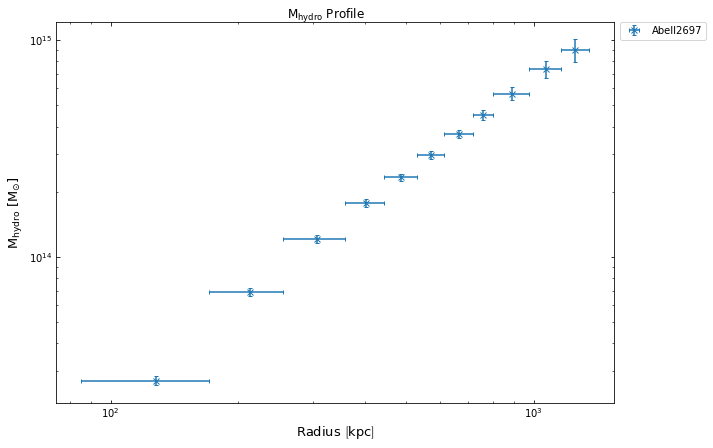

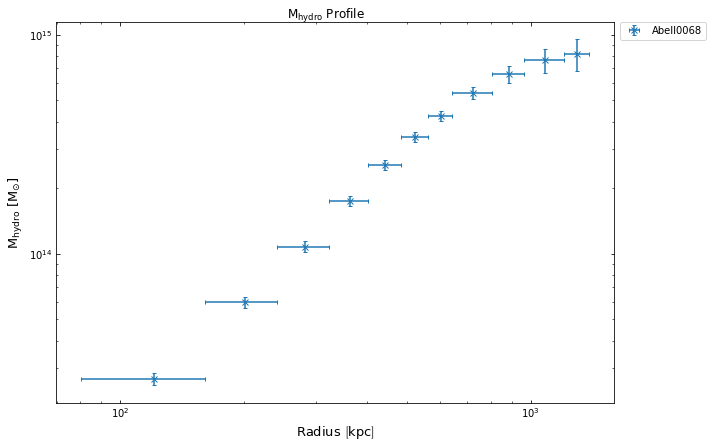

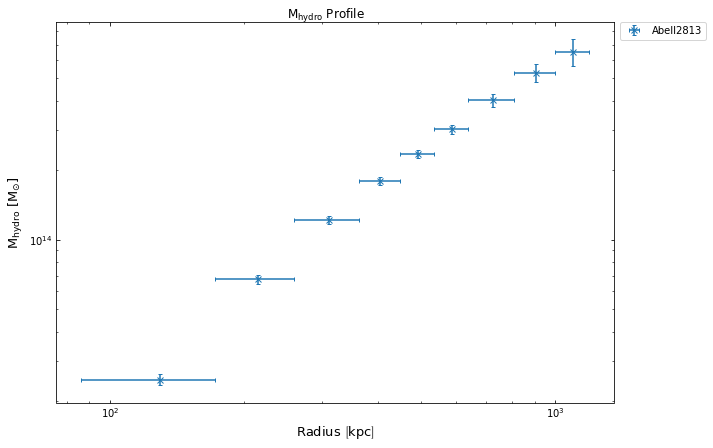

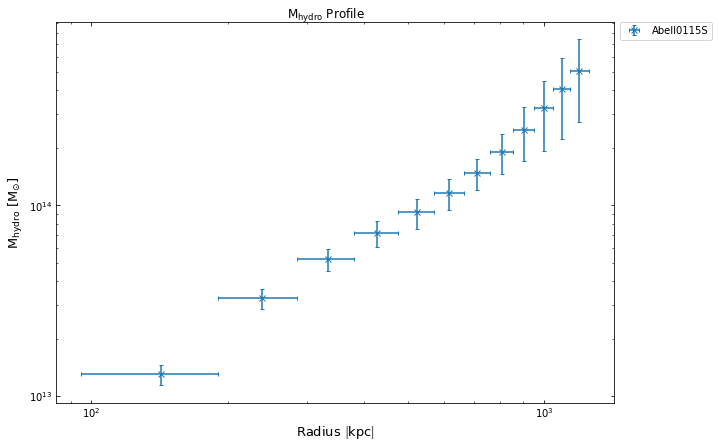

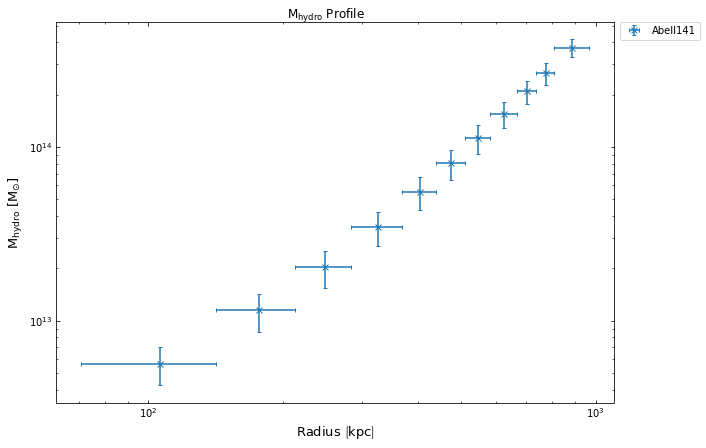

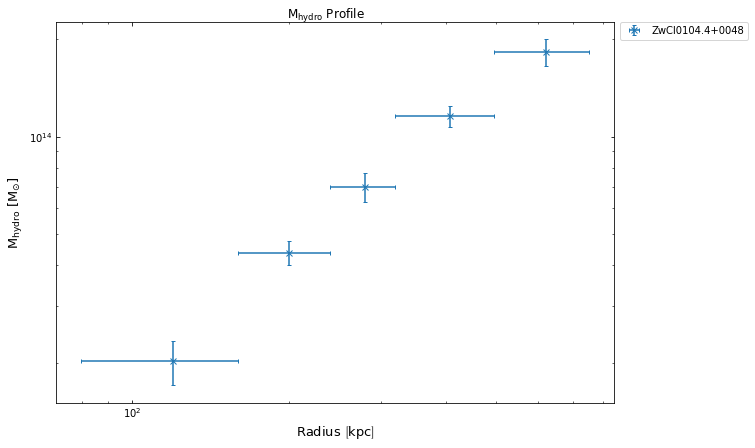

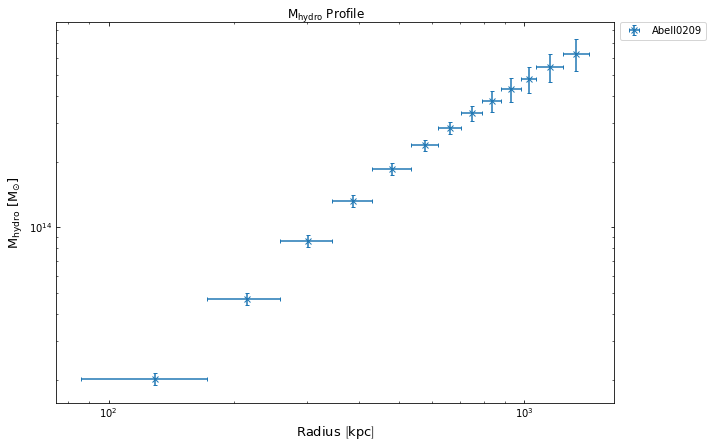

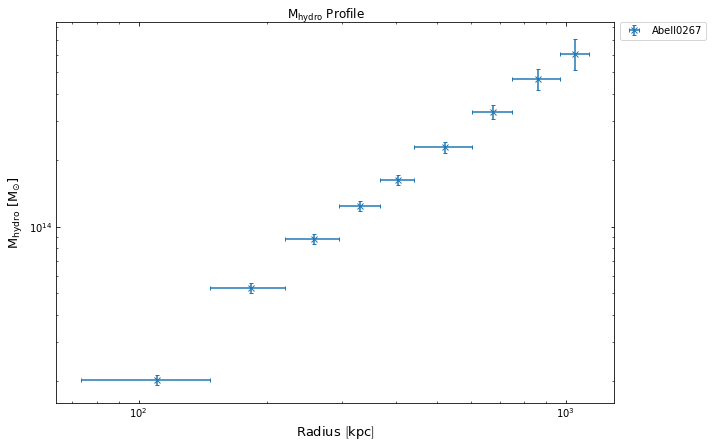

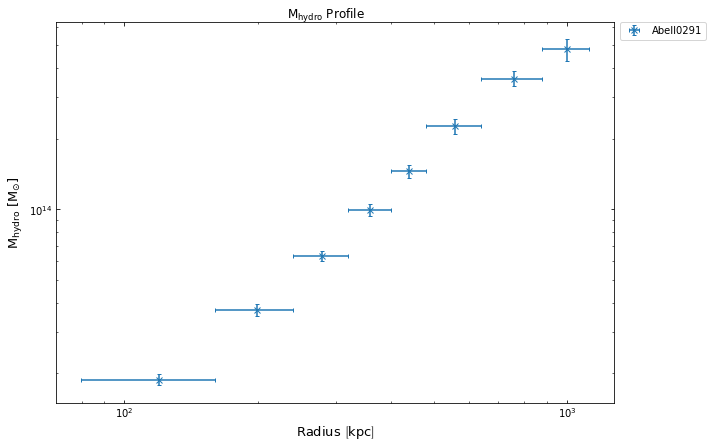

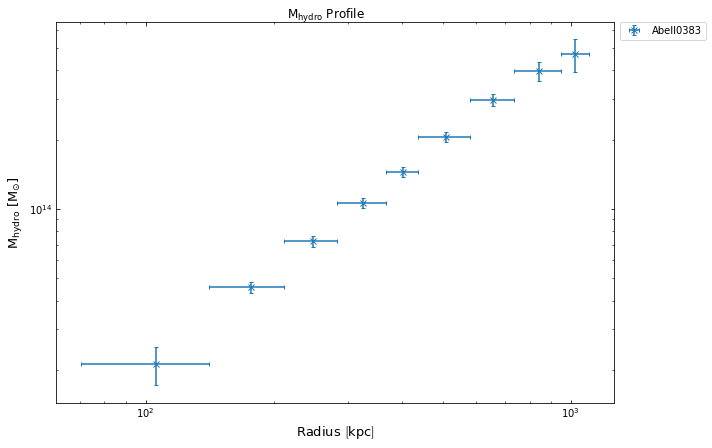

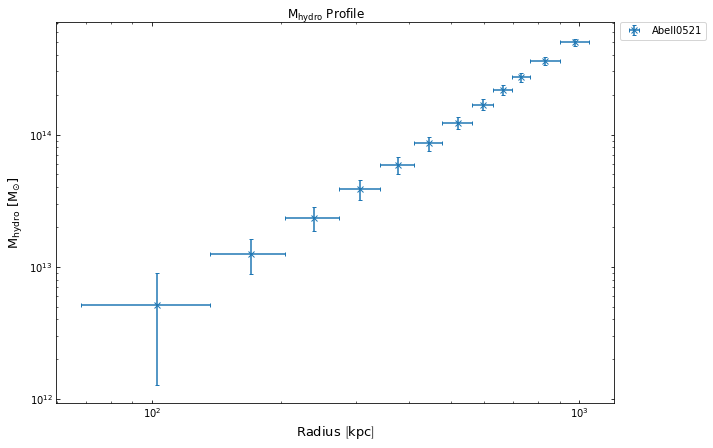

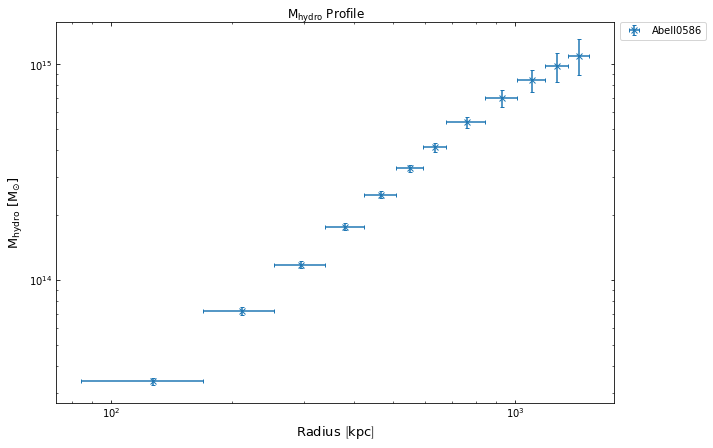

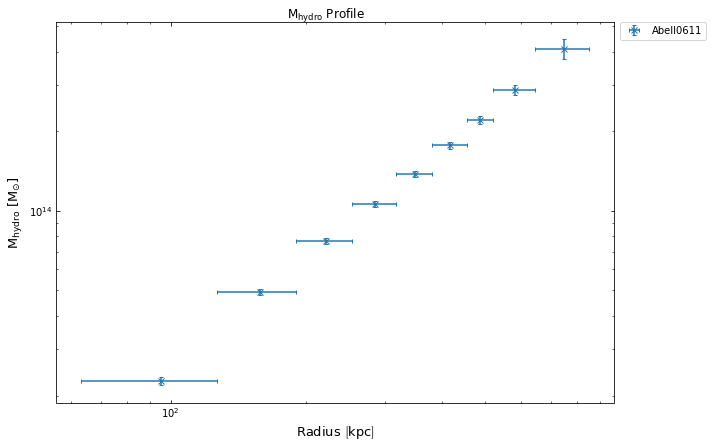

AttributeError: 'NoneType' object has no attribute 'view'

In [19]:
for mp in loc_sb_dblbeta_simpvikh_105_mp:
    mp.view()

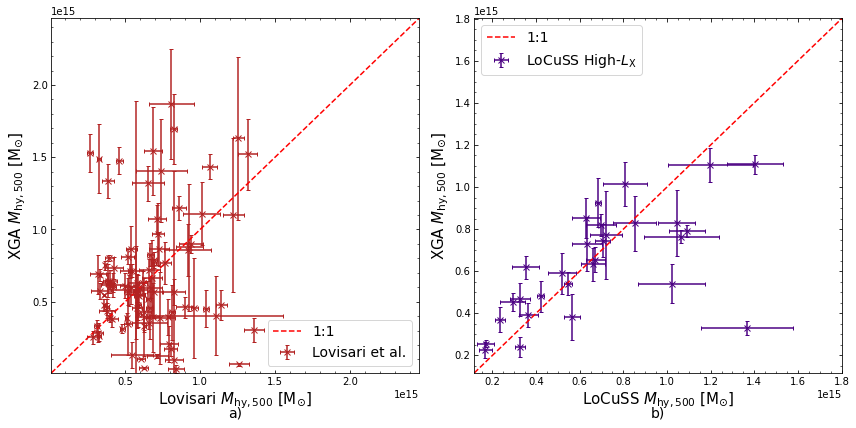

In [24]:
# Setting the y-position and font size of the a and b labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of mass measurements
lov_lims = find_lims(lov_lit_ms, lov_sb_dblbeta_simpvikh_105_m500).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_ms[:, 0].value, lov_sb_dblbeta_simpvikh_105_m500[:, 0].value, 
             xerr=lov_lit_ms[:, 1].value, 
             yerr=lov_sb_dblbeta_simpvikh_105_m500[:, 1].T.value, fmt='x', 
             color=lov_colour, capsize=2, label=r"Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari $M_{\rm{hy, 500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel(r"XGA $M_{\rm{hy,500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of mass measurements
loc_lims = find_lims(loc_lit_ms, loc_sb_dblbeta_simpvikh_105_m500).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties

plt.errorbar(loc_lit_ms[:, 0].value, loc_sb_dblbeta_simpvikh_105_m500[:, 0].value, 
             xerr=loc_lit_ms[:, 1].value, 
             yerr=loc_sb_dblbeta_simpvikh_105_m500[:, 1].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel(r"XGA $M_{\rm{hy,500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/lov_loc_sb_dblbeta_svikh_1.05r500_hym500_comp.pdf")
plt.show()